In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
import OldDecodingTools as odt
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from itertools import product
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages
import h5py
#import tables as tb
from copy import deepcopy
import colorsys
import pingouin as pg

from sklearn.model_selection import GridSearchCV, StratifiedKFold, LeaveOneOut
from sklearn.neighbors import KernelDensity

from scipy import stats

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.weight'] = 'light'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']

act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
ops_directory = 'C:\\Users\insan\\Desktop\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

#opsin
did_learn_animals = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn_animals = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate_animals = ['BS_139','BS_165','BS_191','BS_192']
all_opsin_animals = np.concatenate((did_learn_animals,did_not_learn_animals,indeterminate_animals))

#Ephy
BS_animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']

stdfont = 14
stdyfrac = 0.06

# Animal Behavior

In [2]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\Desktop\EphysAnalysis\Notebooks\TH\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
po

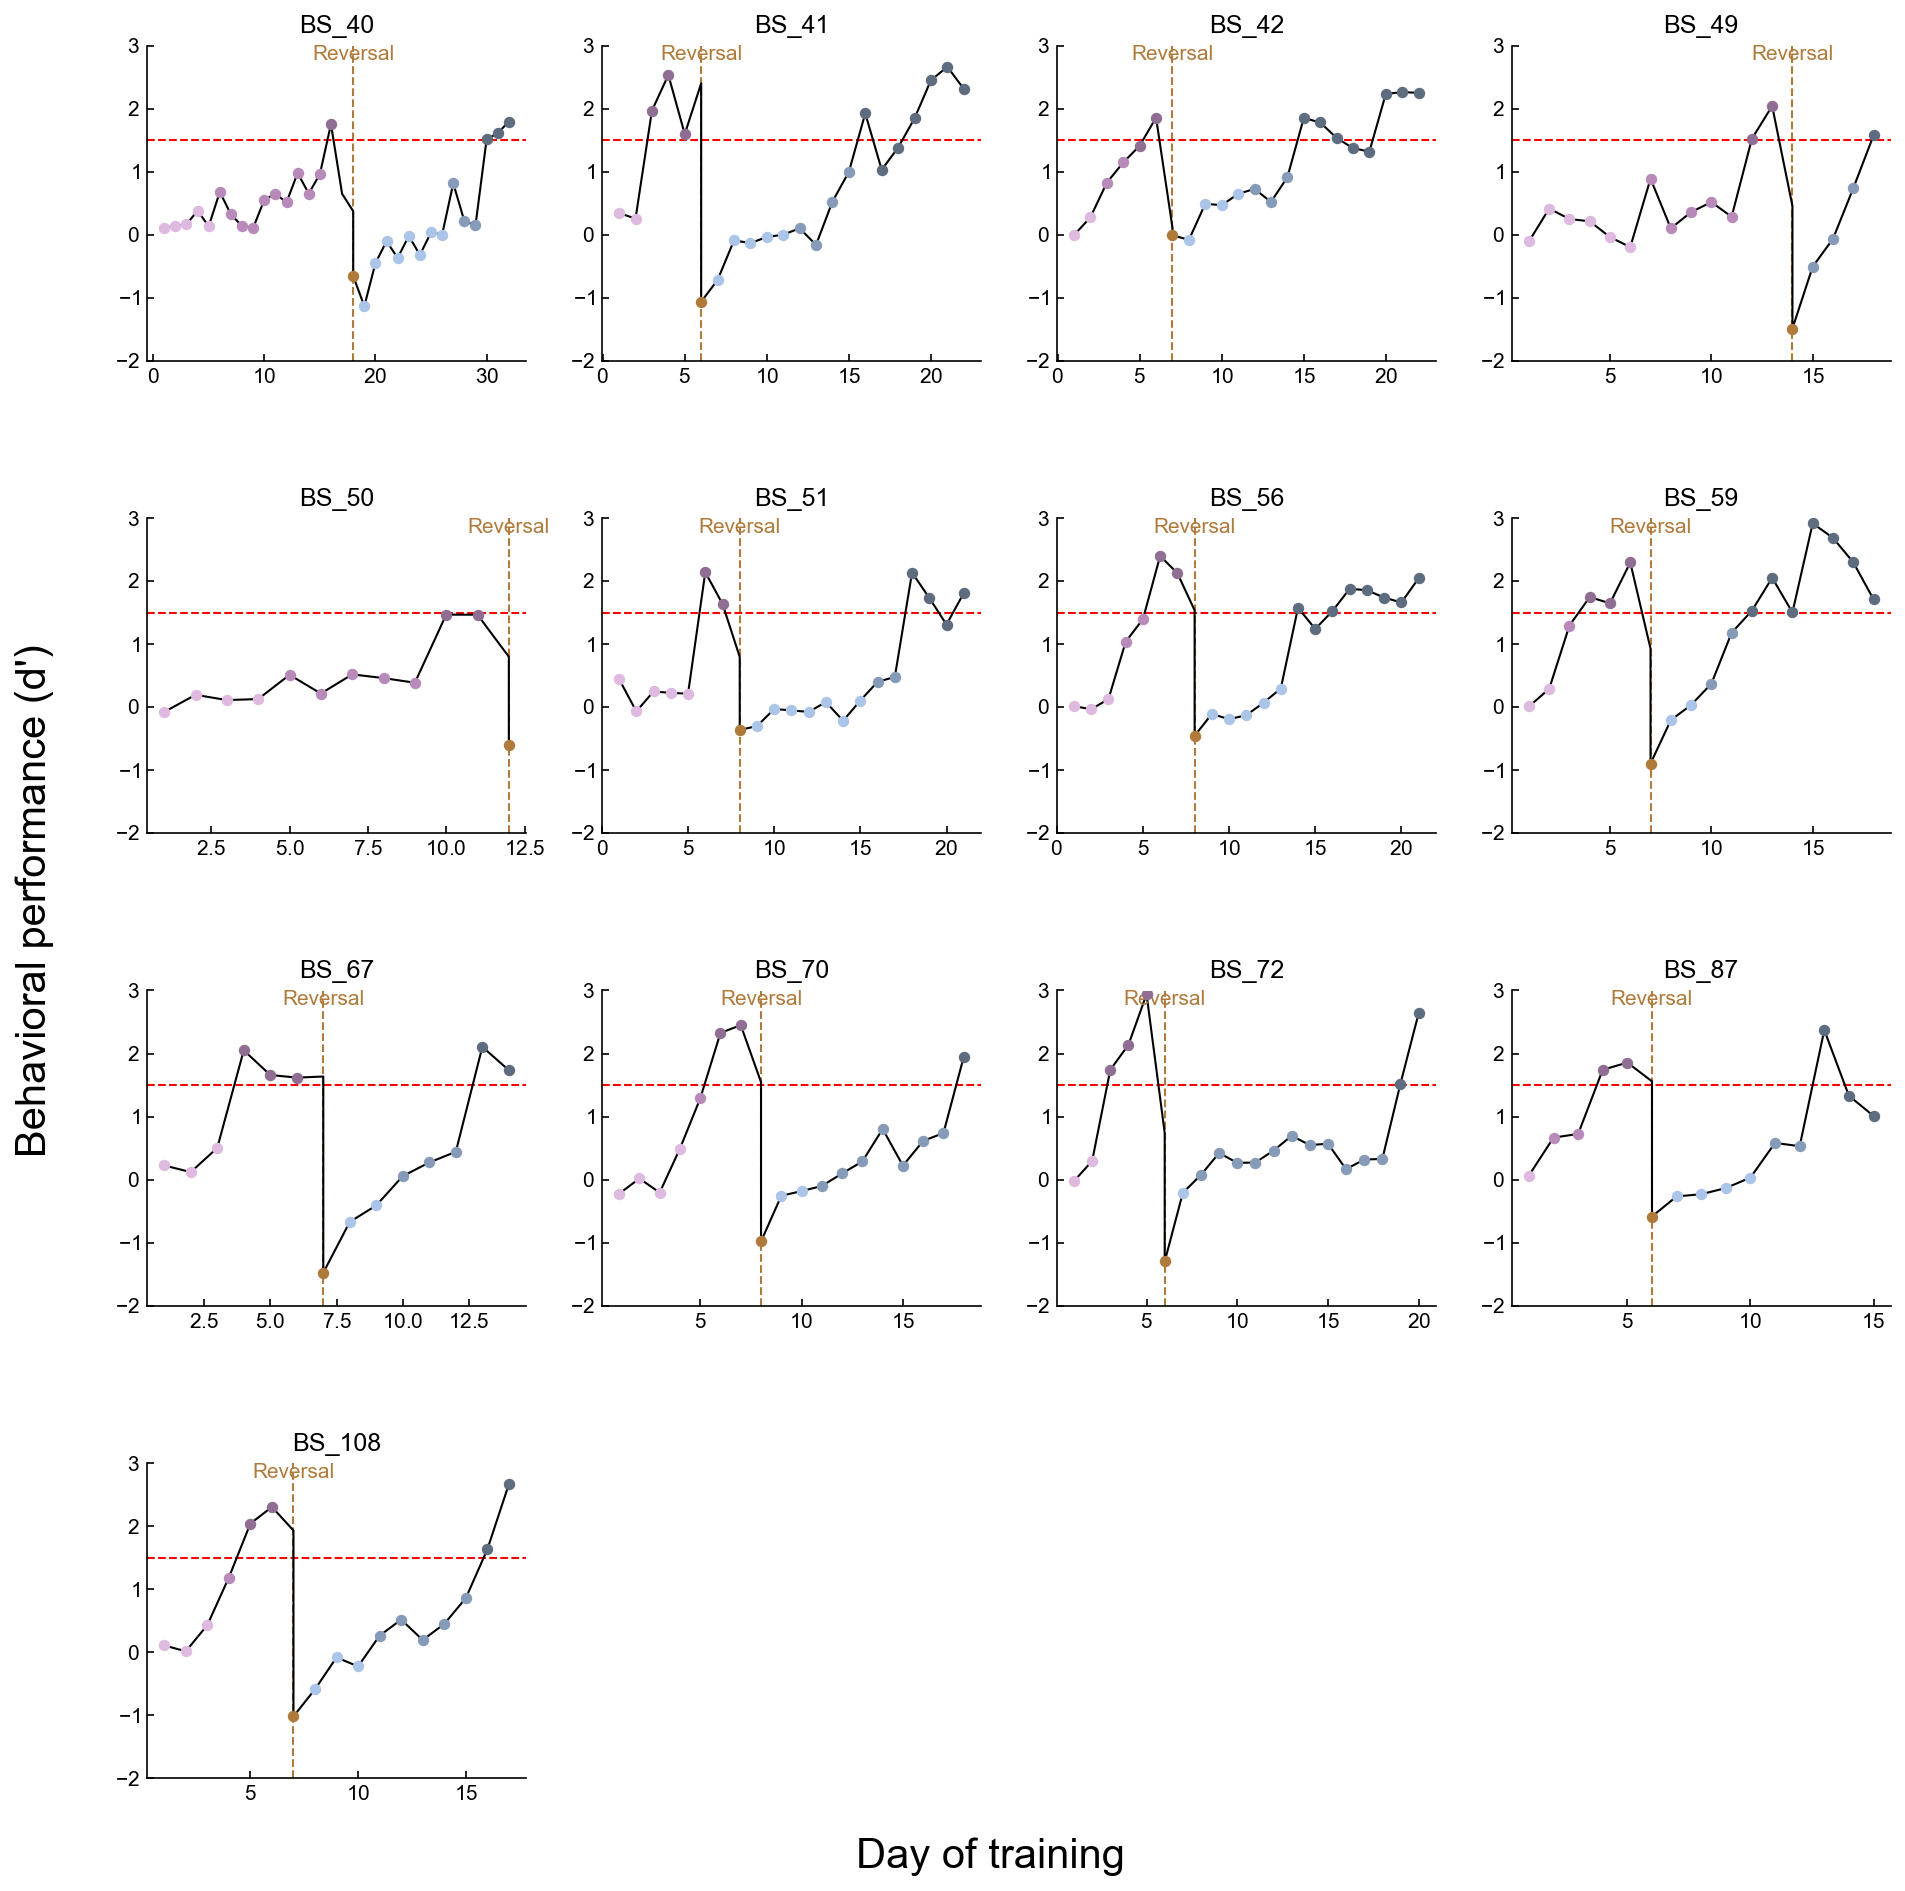

In [3]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(BS_animals,animalBehaviors,plot=True)

# Get data

In [4]:
EnumACSession = []
EnumACClust = []
EnumM2Session = []
EnumM2Clust = []

sessions = os.listdir(act_directory)

numAC = 0
numM2 = 0

for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.task in ['opto nonreversal','opto switch','opto reversal']:
        continue
    if sessionfile.meta.task in ['opto control nonreversal','opto control switch','opto control reversal']:
        continue
    
    if sessionfile.meta.animal not in BS_animals:
        continue
    
    #attribute neurons based on the region
    if sessionfile.meta.region == 'AC':
        numAC += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumACSession.append(session)
            EnumACClust.append(clust)
            
    elif sessionfile.meta.region == 'M2':
        numM2 += len(sessionfile.clusters.good)
        
        for clust in sessionfile.clusters.good:
            EnumM2Session.append(session)
            EnumM2Clust.append(clust)    
    else:
        pass
        


        
print('AC       : ' + str(numAC))
print('M2       : ' + str(numM2))

100%|██████████| 722/722 [00:13<00:00, 55.50it/s]

AC       : 1288
M2       : 1628


## Assign learning phase

In [5]:
EILM2phases = np.full_like(EnumM2Session,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumM2Session)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILM2phases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILM2phases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILM2phases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILM2phases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILM2phases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILM2phases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILM2phases[idx] = 'post expert'
    except Exception as e:
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1628/1628 [00:29<00:00, 55.45it/s] 

errors for: []


In [6]:
EILACphases = np.full_like(EnumACSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumACSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            EILACphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILACphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILACphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILACphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            EILACphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            EILACphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            EILACphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1288/1288 [00:27<00:00, 46.30it/s] 

errors for: []


In [7]:
EILACphases

array(['pre expert', 'pre expert', 'pre expert', ..., 'post late',
       'post late', 'post late'], dtype='<U18')

In [8]:
EILM2phases

array(['pre expert', 'pre expert', 'pre expert', ..., 'post late',
       'post late', 'post late'], dtype='<U18')

In [9]:
print(len(EILACphases))
print(len(EILM2phases))

1288
1628


In [10]:
preearly_animals_M2 = []
prelate_animals_M2  = []
preexpert_animals_M2  = []
postearly_animals_M2  = []
postlate_animals_M2  = []
postexpert_animals_M2  = []

FRmod_preearly_M2 = []
FRmod_prelate_M2 = []
FRmod_preexpert_M2 = []
FRmod_postearly_M2 = []
FRmod_postlate_M2 = []
FRmod_postexpert_M2 = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumM2Session,EnumM2Clust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    if EILM2phases[idx] == 'pre early':
        FRmod_preearly_M2.append(FRmod)
        preearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'pre late':
        FRmod_prelate_M2.append(FRmod)
        prelate_animals_M2.append(sessionfile.meta.animal)  
        
    elif EILM2phases[idx] == 'pre expert':
        FRmod_preexpert_M2.append(FRmod)
        preexpert_animals_M2.append(sessionfile.meta.animal)     
        
    elif EILM2phases[idx] == 'post early':
        FRmod_postearly_M2.append(FRmod)
        postearly_animals_M2.append(sessionfile.meta.animal)   
        
    elif EILM2phases[idx] == 'post late':
        FRmod_postlate_M2.append(FRmod)
        postlate_animals_M2.append(sessionfile.meta.animal)    
        
    elif EILM2phases[idx] == 'post expert':
        FRmod_postexpert_M2.append(FRmod)
        postexpert_animals_M2.append(sessionfile.meta.animal)

FRmod_preearly_M2 = np.array(FRmod_preearly_M2)
FRmod_prelate_M2 = np.array(FRmod_prelate_M2)
FRmod_preexpert_M2 = np.array(FRmod_preexpert_M2)
FRmod_postearly_M2 = np.array(FRmod_postearly_M2)
FRmod_postlate_M2 = np.array(FRmod_postlate_M2)
FRmod_postexpert_M2 = np.array(FRmod_postexpert_M2)

1628it [00:29, 54.67it/s] 


In [11]:
len(FRmod_preearly_M2)

159

In [12]:
preearly_animals_AC = []
prelate_animals_AC  = []
preexpert_animals_AC  = []
postearly_animals_AC  = []
postlate_animals_AC  = []
postexpert_animals_AC  = []

FRmod_preearly_AC = []
FRmod_prelate_AC = []
FRmod_preexpert_AC = []
FRmod_postearly_AC = []
FRmod_postlate_AC = []
FRmod_postexpert_AC = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    if EILACphases[idx] == 'pre early':
        FRmod_preearly_AC.append(FRmod)
        preearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'pre late':
        FRmod_prelate_AC.append(FRmod)
        prelate_animals_AC.append(sessionfile.meta.animal)  
        
    elif EILACphases[idx] == 'pre expert':
        FRmod_preexpert_AC.append(FRmod)
        preexpert_animals_AC.append(sessionfile.meta.animal)     
        
    elif EILACphases[idx] == 'post early':
        FRmod_postearly_AC.append(FRmod)
        postearly_animals_AC.append(sessionfile.meta.animal)   
        
    elif EILACphases[idx] == 'post late':
        FRmod_postlate_AC.append(FRmod)
        postlate_animals_AC.append(sessionfile.meta.animal)    
        
    elif EILACphases[idx] == 'post expert':
        FRmod_postexpert_AC.append(FRmod)
        postexpert_animals_AC.append(sessionfile.meta.animal)

FRmod_preearly_AC = np.array(FRmod_preearly_AC)
FRmod_prelate_AC = np.array(FRmod_prelate_AC)
FRmod_preexpert_AC = np.array(FRmod_preexpert_AC)
FRmod_postearly_AC = np.array(FRmod_postearly_AC)
FRmod_postlate_AC = np.array(FRmod_postlate_AC)
FRmod_postexpert_AC = np.array(FRmod_postexpert_AC)

1288it [00:28, 45.18it/s] 


In [13]:
preearly_animals_M2 = np.unique(preearly_animals_M2)
prelate_animals_M2 = np.unique(prelate_animals_M2)
preexpert_animals_M2 = np.unique(preexpert_animals_M2)
postearly_animals_M2 = np.unique(postearly_animals_M2)
postlate_animals_M2 = np.unique(postlate_animals_M2)
postexpert_animals_M2 = np.unique(postexpert_animals_M2)

preearly_animals_AC = np.unique(preearly_animals_AC)
prelate_animals_AC = np.unique(prelate_animals_AC)
preexpert_animals_AC = np.unique(preexpert_animals_AC)
postearly_animals_AC = np.unique(postearly_animals_AC)
postlate_animals_AC = np.unique(postlate_animals_AC)
postexpert_animals_AC = np.unique(postexpert_animals_AC)

print('M2 Animals')
print(preearly_animals_M2)
print(prelate_animals_M2)
print(preexpert_animals_M2)
print(postearly_animals_M2)
print(postlate_animals_M2)
print(postexpert_animals_M2)
print('AC Animals')
print(preearly_animals_AC)
print(prelate_animals_AC)
print(preexpert_animals_AC)
print(postearly_animals_AC)
print(postlate_animals_AC)
print(postexpert_animals_AC)

###MAY NEED TO MATCH AC AND M2 ANIMALS!!!

M2 Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_50' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_108' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_41' 'BS_42' 'BS_51' 'BS_56' 'BS_59' 'BS_67' 'BS_87']
AC Animals
['BS_49' 'BS_50']
['BS_40' 'BS_49' 'BS_50' 'BS_70']
['BS_108' 'BS_40' 'BS_49' 'BS_72' 'BS_87']
['BS_108' 'BS_40' 'BS_41' 'BS_42' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_67' 'BS_70' 'BS_72' 'BS_87']
['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_51' 'BS_56' 'BS_67' 'BS_70' 'BS_87']


In [14]:
print(len(FRmod_preearly_AC))
print(len(FRmod_prelate_AC))
print(len(FRmod_preexpert_AC))
print(len(FRmod_postearly_AC))
print(len(FRmod_postlate_AC))
print(len(FRmod_postexpert_AC))

148
188
75
349
299
103


In [15]:
print(len(FRmod_preearly_M2))
print(len(FRmod_prelate_M2))
print(len(FRmod_preexpert_M2))
print(len(FRmod_postearly_M2))
print(len(FRmod_postlate_M2))
print(len(FRmod_postexpert_M2))

159
240
199
349
204
218


In [16]:
len(ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded=None)['all_trials'].trials)

231

In [17]:
len(ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded=None)['target'].trials)

115

In [18]:
len(ilep.getAllConditions(sessionfile,clust,trialsPerDayLoaded=None)['nontarget'].trials)

116

### Only calculate a pair-wise corr for a pair within one session and one learning phease

In [19]:
AC_sessions = np.unique(EnumACSession)
M2_sessions = np.unique(EnumM2Session)

print(len(AC_sessions))
print(len(M2_sessions))

99
103


In [20]:
AC_sessions

array(['BS_108_1_AC.pickle', 'BS_108_2_AC.pickle', 'BS_108_3_AC.pickle',
       'BS_108_4_AC.pickle', 'BS_108_6_AC.pickle', 'BS_40_10_AC.pickle',
       'BS_40_12_AC.pickle', 'BS_40_14_AC.pickle', 'BS_40_15_AC.pickle',
       'BS_40_16_AC.pickle', 'BS_40_18_AC.pickle', 'BS_40_19_AC.pickle',
       'BS_40_21_AC.pickle', 'BS_40_22_AC.pickle', 'BS_40_2_AC.pickle',
       'BS_40_3_AC.pickle', 'BS_40_4_AC.pickle', 'BS_40_5_AC.pickle',
       'BS_40_6_AC.pickle', 'BS_40_7_AC.pickle', 'BS_40_8_AC.pickle',
       'BS_41_10_AC.pickle', 'BS_41_11_AC.pickle', 'BS_41_1_AC.pickle',
       'BS_41_2_AC.pickle', 'BS_41_4_AC.pickle', 'BS_41_5_AC.pickle',
       'BS_41_6_AC.pickle', 'BS_41_7_AC.pickle', 'BS_41_8_AC.pickle',
       'BS_41_9_AC.pickle', 'BS_42_10_AC.pickle', 'BS_42_11_AC.pickle',
       'BS_42_1_AC.pickle', 'BS_42_2_AC.pickle', 'BS_42_3_AC.pickle',
       'BS_42_4_AC.pickle', 'BS_42_5_AC.pickle', 'BS_42_6_AC.pickle',
       'BS_42_7_AC.pickle', 'BS_42_8_AC.pickle', 'BS_42_9_AC.pickle',
  

In [21]:
M2phases = np.full_like(M2_sessions,np.nan)
error_animals = []

M2_switch = []
M2_preearly = []
M2_prelate = []
M2_preexpert = []
M2_postearly = []
M2_postlate = []
M2_postexpert = []

for idx,session in enumerate(tqdm(M2_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            M2phases[idx] = 'switch'
            M2_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            M2phases[idx] = 'pre early'
            M2_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            M2phases[idx] = 'pre late'
            M2_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            M2phases[idx] = 'pre expert'
            M2_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            M2phases[idx] = 'post early'
            M2_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            M2phases[idx] = 'post late'
            M2_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            M2phases[idx] = 'post expert'
            M2_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

print(len(M2phases))
print(len(M2_preearly))
print(len(M2_prelate))
print(len(M2_preexpert))
print(len(M2_postearly))
print(len(M2_postlate))
print(len(M2_postexpert))
print(len(M2_switch))
7+13+10+19+24+19+9

100%|██████████| 103/103 [00:01<00:00, 89.57it/s]

errors for: []
103
7
13
10
19
24
19
9


101

In [22]:
ACphases = np.full_like(AC_sessions,np.nan)
error_animals = []

AC_switch = []
AC_preearly = []
AC_prelate = []
AC_preexpert = []
AC_postearly = []
AC_postlate = []
AC_postexpert = []

for idx,session in enumerate(tqdm(AC_sessions)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch']:
            ACphases[idx] = 'switch'
            AC_switch.append(session)

        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_early_days:
            ACphases[idx] = 'pre early'
            AC_preearly.append(session)
            
        elif sessionfile.meta.task in ['nonreversal']  and day in learning_phases[animal].pre_late_days:
            ACphases[idx] = 'pre late'
            AC_prelate.append(session)
            
        elif sessionfile.meta.task in ['nonreversal'] and day in learning_phases[animal].pre_expert_days:
            ACphases[idx] = 'pre expert'
            AC_preexpert.append(session)

        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_early_days:
            ACphases[idx] = 'post early'
            AC_postearly.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_late_days:
            ACphases[idx] = 'post late'
            AC_postlate.append(session)
            
        elif sessionfile.meta.task in ['reversal']  and day in learning_phases[animal].post_expert_days:
            ACphases[idx] = 'post expert'
            AC_postexpert.append(session)
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

print(len(ACphases))
print(len(AC_preearly))
print(len(AC_prelate))
print(len(AC_preexpert))
print(len(AC_postearly))
print(len(AC_postlate))
print(len(AC_postexpert))
print(len(AC_switch))
6+14+10+36+26+31+8

100%|██████████| 99/99 [00:01<00:00, 77.03it/s] 

errors for: []
99
6
14
8
20
24
20
6


131

# Calculation

# Pairwise correlation between a pair of neurons 

In [23]:
#Calculate pairwise correlation between pairs in one session in one region
#Steps:
#Define sessionfile, get good clusters from this sessionfile
#Get all pairs from this session
#For each pair, get trials to use, calculate spike count residual for each cell in this pair, then calculate the pearson correlation
#Go to next pair

In [24]:
#Get one session's pairs
def getSessionPairs(sessionfile):
    #get good clusters from this sessionfile
    sessionfile_clust = []
    for clust in sessionfile.clusters.good:
        sessionfile_clust.append(clust)

    cluster_pairs = [(sessionfile_clust[i],sessionfile_clust[j]) for i in range(len(sessionfile_clust)) for j in range(i+1,len(sessionfile_clust))]
    
    return cluster_pairs
    

In [25]:
#Trials to use for each pair of cell should be the same, use the intersection
def getTrialsforPair(sessionfile,clustA,clustB,trial_condition):
    trials_to_use_A = ilep.getAllConditions(sessionfile,clustA,trialsPerDayLoaded=None)[trial_condition]
    trials_to_use_A = trials_to_use_A.trials
    #print(len(trials_to_use_A))
    
    trials_to_use_B = ilep.getAllConditions(sessionfile,clustB,trialsPerDayLoaded=None)[trial_condition]
    trials_to_use_B = trials_to_use_B.trials
    #print(len(trials_to_use_B))
    
    trials_to_use = np.intersect1d(trials_to_use_A,trials_to_use_B)
    #print(len(trials_to_use))
          
    return trials_to_use

In [26]:
#Count a cell's spike counts residual across all trials to use
def countClustSpikes_alltrials(sessionfile,clust,window_length,trials_to_use):

    start_times = sessionfile.trials.starts
    start_times = [start_times[trial_id] for trial_id in trials_to_use]
    #print(len(start_times))
    
    spike_time_trials = []
    for start_time in start_times:
        end_time = start_time + window_length*30000 
        spike_time = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start_time,endtime=end_time)
        spike_time_trials.append(spike_time)
    #print(len(spike_time_trials))
          
    spike_count_trials = []
    for spiketime in spike_time_trials:
        spike_count = len(spiketime)
        spike_count_trials.append(spike_count)
    #print(len(spike_count_trials))
    
    spike_count_trials = np.array(spike_count_trials)
    spike_count_mean = np.mean(spike_count_trials)
    res_spike_count_trials = spike_count_trials - spike_count_mean
    
    return spike_count_trials, spike_count_mean, res_spike_count_trials

In [27]:
#Using a 200ms window from the start of the trial to count for the spikes
window_length = 0.2 #200ms


# All cells calculation (both AC and M2, within region calculation)

In [55]:
def calculateSessionCorr(session,trial_condition):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    cluster_pairs = getSessionPairs(sessionfile)
    
    session_corr = []
    session_pval = []
    #For each pair, get trials to use, calculate spike count residual for each cell in this pair, then calculate the pearson correlation
    for clust_pair in cluster_pairs:
        #For each pair
        clustA = clust_pair[0]
        clustB = clust_pair[1]

        #Get trials to use
        trials_to_use = getTrialsforPair(sessionfile,clustA,clustB,trial_condition)
        
        trial_thres = 100
        if len(trials_to_use) >=trial_thres:
            #calculate spike count residual for each cell in this pair
            res_spike_count_trials_A = countClustSpikes_alltrials(sessionfile,clustA,window_length,trials_to_use)[2]
            res_spike_count_trials_B = countClustSpikes_alltrials(sessionfile,clustB,window_length,trials_to_use)[2]

            #calculate the pearson correlation between this pair
            corr = stats.pearsonr(res_spike_count_trials_A,res_spike_count_trials_B)[0]
            pval = stats.pearsonr(res_spike_count_trials_A,res_spike_count_trials_B)[1]
            session_corr.append(corr)
            session_pval.append(pval)
            
    return session_corr
    
    

In [59]:
sessionfile=AC_preearly[0]
session_corr = calculateSessionCorr(sessionfile,'target')

In [58]:
session_corr 

[0.12383511821199399,
 -0.035281363691473645,
 0.2591637972546699,
 -0.032334379303176966,
 -0.11920907351752819,
 0.03740230681337399,
 -0.017929863579879225,
 0.03426418389362842,
 0.01187997991839592,
 0.058168847861397685,
 -0.1104264013289754,
 0.30609177239137775,
 -0.0642634304937934,
 0.07193625547664559,
 0.14312939881317574,
 0.05069470249746088,
 0.03456994327920425,
 -0.05947667774595061,
 0.062432984263919626,
 0.04376454478043976,
 0.07732884392526294,
 -0.028485001939817744,
 0.004042627399026793,
 0.11257747372784889,
 0.0008734132451301336,
 0.009554915436983879,
 0.028451608650012162,
 0.012784051266953011,
 -0.023018381145029874,
 0.10988788281228738,
 0.10141207191010869,
 -0.046991050991631755,
 -0.02023412363832328,
 0.006419138034607143,
 -0.16878931596885433,
 -0.043693354939976524,
 -0.01639124067610728,
 0.020040418491060526,
 0.014094920151912622,
 0.07142154577065823,
 -0.11017494492631488,
 0.009421185145489123,
 -0.08820826769442901,
 0.03231611364759494,


### Target trials

In [29]:
AC_target_preearly_corr = []
AC_target_prelate_corr = []
AC_target_preexpert_corr = []
AC_target_postearly_corr = []
AC_target_postlate_corr = []
AC_target_postexpert_corr = []

M2_target_preearly_corr = []
M2_target_prelate_corr = []
M2_target_preexpert_corr = []
M2_target_postearly_corr = []
M2_target_postlate_corr = []
M2_target_postexpert_corr = []

In [30]:
#Pre
for session in AC_preearly:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_preearly_corr.extend(session_corr)

for session in AC_prelate:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_prelate_corr.extend(session_corr)
    
for session in AC_preexpert:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_preexpert_corr.extend(session_corr)
    
for session in M2_preearly:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_preearly_corr.extend(session_corr)

for session in M2_prelate:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_prelate_corr.extend(session_corr)
    
for session in M2_preexpert:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_preexpert_corr.extend(session_corr)

#Post
for session in AC_postearly:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_postearly_corr.extend(session_corr)

for session in AC_postlate:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_postlate_corr.extend(session_corr)
    
for session in AC_postexpert:
    session_corr = calculateSessionCorr(session,'target')
    AC_target_postexpert_corr.extend(session_corr)
    
for session in M2_postearly:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_postearly_corr.extend(session_corr)

for session in M2_postlate:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_postlate_corr.extend(session_corr)
    
for session in M2_postexpert:
    session_corr = calculateSessionCorr(session,'target')
    M2_target_postexpert_corr.extend(session_corr)

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\scipy\stats\_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [31]:
print(len(AC_target_preearly_corr))
print(len(AC_target_prelate_corr))
print(len(AC_target_preexpert_corr))
print(len(AC_target_postearly_corr))
print(len(AC_target_postlate_corr))
print(len(AC_target_postexpert_corr))

# AC_target_preearly_corr = np.array(AC_target_preearly_corr)
# AC_target_prelate_corr = np.array(AC_target_prelate_corr)
# AC_target_preexpert_corr = np.array(AC_target_preexpert_corr)
# AC_target_postearly_corr = np.array(AC_target_postearly_corr)
# AC_target_postlate_corr = np.array(AC_target_postlate_corr)
# AC_target_postexpert_corr = np.array(AC_target_postexpert_corr)

print(len(M2_target_preearly_corr))
print(len(M2_target_prelate_corr))
print(len(M2_target_preexpert_corr))
print(len(M2_target_postearly_corr))
print(len(M2_target_postlate_corr))
print(len(M2_target_postexpert_corr))

# M2_target_preearly_corr = np.array(M2_target_preearly_corr)
# M2_target_prelate_corr = np.array(M2_target_prelate_corr)
# M2_target_preexpert_corr = np.array(M2_target_preexpert_corr)
# M2_target_postearly_corr = np.array(M2_target_postearly_corr)
# M2_target_postlate_corr = np.array(M2_target_postlate_corr)
# M2_target_postexpert_corr = np.array(M2_target_postexpert_corr)


1478
1728
36
3665
2092
156
593
2799
253
3018
1265
1043


In [32]:
AC_pairwise_corr_target = SimpleNamespace(prereversal_early=AC_target_preearly_corr,
                      prereversal_late=AC_target_prelate_corr,
                      prereversal_expert=AC_target_preexpert_corr,
                      postreversal_early=AC_target_postearly_corr,
                      postreversal_late=AC_target_postlate_corr,
                      postreversal_expert=AC_target_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_corr_target.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_corr_target, f, protocol=pickle.HIGHEST_PROTOCOL)

    
M2_pairwise_corr_target = SimpleNamespace(prereversal_early=M2_target_preearly_corr,
                      prereversal_late=M2_target_prelate_corr,
                      prereversal_expert=M2_target_preexpert_corr,
                      postreversal_early=M2_target_postearly_corr,
                      postreversal_late=M2_target_postlate_corr,
                      postreversal_expert=M2_target_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_pairwise_corr_target.pickle'
with open(filename, 'wb') as f:
    pickle.dump(M2_pairwise_corr_target, f, protocol=pickle.HIGHEST_PROTOCOL)

### Nontarget trials

In [33]:
AC_nontarget_preearly_corr = []
AC_nontarget_prelate_corr = []
AC_nontarget_preexpert_corr = []
AC_nontarget_postearly_corr = []
AC_nontarget_postlate_corr = []
AC_nontarget_postexpert_corr = []

M2_nontarget_preearly_corr = []
M2_nontarget_prelate_corr = []
M2_nontarget_preexpert_corr = []
M2_nontarget_postearly_corr = []
M2_nontarget_postlate_corr = []
M2_nontarget_postexpert_corr = []

In [34]:
#Pre
for session in AC_preearly:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_preearly_corr.extend(session_corr)

for session in AC_prelate:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_prelate_corr.extend(session_corr)
    
for session in AC_preexpert:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_preexpert_corr.extend(session_corr)
    
for session in M2_preearly:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_preearly_corr.extend(session_corr)

for session in M2_prelate:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_prelate_corr.extend(session_corr)
    
for session in M2_preexpert:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_preexpert_corr.extend(session_corr)

#Post
for session in AC_postearly:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_postearly_corr.extend(session_corr)

for session in AC_postlate:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_postlate_corr.extend(session_corr)
    
for session in AC_postexpert:
    session_corr = calculateSessionCorr(session,'nontarget')
    AC_nontarget_postexpert_corr.extend(session_corr)
    
for session in M2_postearly:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_postearly_corr.extend(session_corr)

for session in M2_postlate:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_postlate_corr.extend(session_corr)
    
for session in M2_postexpert:
    session_corr = calculateSessionCorr(session,'nontarget')
    M2_nontarget_postexpert_corr.extend(session_corr)

In [35]:
print(len(AC_nontarget_preearly_corr))
print(len(AC_nontarget_prelate_corr))
print(len(AC_nontarget_preexpert_corr))
print(len(AC_nontarget_postearly_corr))
print(len(AC_nontarget_postlate_corr))
print(len(AC_nontarget_postexpert_corr))

# AC_nontarget_preearly_corr = np.array(AC_nontarget_preearly_corr)
# AC_nontarget_prelate_corr = np.array(AC_nontarget_prelate_corr)
# AC_nontarget_preexpert_corr = np.array(AC_nontarget_preexpert_corr)
# AC_nontarget_postearly_corr = np.array(AC_nontarget_postearly_corr)
# AC_nontarget_postlate_corr = np.array(AC_nontarget_postlate_corr)
# AC_nontarget_postexpert_corr = np.array(AC_nontarget_postexpert_corr)

print(len(M2_nontarget_preearly_corr))
print(len(M2_nontarget_prelate_corr))
print(len(M2_nontarget_preexpert_corr))
print(len(M2_nontarget_postearly_corr))
print(len(M2_nontarget_postlate_corr))
print(len(M2_nontarget_postexpert_corr))

# M2_nontarget_preearly_corr = np.array(M2_nontarget_preearly_corr)
# M2_nontarget_prelate_corr = np.array(M2_nontarget_prelate_corr)
# M2_nontarget_preexpert_corr = np.array(M2_nontarget_preexpert_corr)
# M2_nontarget_postearly_corr = np.array(M2_nontarget_postearly_corr)
# M2_nontarget_postlate_corr = np.array(M2_nontarget_postlate_corr)
# M2_nontarget_postexpert_corr = np.array(M2_nontarget_postexpert_corr)

1391
1606
36
3592
2038
156
576
2704
253
2822
1133
1043


In [36]:
AC_pairwise_corr_nontarget = SimpleNamespace(prereversal_early=AC_nontarget_preearly_corr,
                      prereversal_late=AC_nontarget_prelate_corr,
                      prereversal_expert=AC_nontarget_preexpert_corr,
                      postreversal_early=AC_nontarget_postearly_corr,
                      postreversal_late=AC_nontarget_postlate_corr,
                      postreversal_expert=AC_nontarget_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_corr_nontarget.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_corr_nontarget, f, protocol=pickle.HIGHEST_PROTOCOL)

    
M2_pairwise_corr_nontarget = SimpleNamespace(prereversal_early=M2_nontarget_preearly_corr,
                      prereversal_late=M2_nontarget_prelate_corr,
                      prereversal_expert=M2_nontarget_preexpert_corr,
                      postreversal_early=M2_nontarget_postearly_corr,
                      postreversal_late=M2_nontarget_postlate_corr,
                      postreversal_expert=M2_nontarget_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_pairwise_corr_nontarget.pickle'
with open(filename, 'wb') as f:
    pickle.dump(M2_pairwise_corr_nontarget, f, protocol=pickle.HIGHEST_PROTOCOL)

### All trials

In [37]:
AC_preearly_corr = []
AC_prelate_corr = []
AC_preexpert_corr = []
AC_postearly_corr = []
AC_postlate_corr = []
AC_postexpert_corr = []

M2_preearly_corr = []
M2_prelate_corr = []
M2_preexpert_corr = []
M2_postearly_corr = []
M2_postlate_corr = []
M2_postexpert_corr = []

In [38]:
#Pre
for session in AC_preearly:
    session_corr = calculateSessionCorr(session,'all_trials')
    AC_preearly_corr.extend(session_corr)

for session in AC_prelate:
    session_corr = calculateSessionCorr(session,'all_trials')
    AC_prelate_corr.extend(session_corr)
    
for session in AC_preexpert:
    session_corr = calculateSessionCorr(session,'all_trials')
    AC_preexpert_corr.extend(session_corr)
    
for session in M2_preearly:
    session_corr = calculateSessionCorr(session,'all_trials')
    M2_preearly_corr.extend(session_corr)

for session in M2_prelate:
    session_corr = calculateSessionCorr(session,'all_trials')
    M2_prelate_corr.extend(session_corr)
    
for session in M2_preexpert:
    session_corr = calculateSessionCorr(session,'all_trials')
    M2_preexpert_corr.extend(session_corr)

#Post
for session in AC_postearly:
    session_corr = calculateSessionCorr(session,'all_trials')
    AC_postearly_corr.extend(session_corr)

for session in AC_postlate:
    session_corr = calculateSessionCorr(session,'all_trials')
    AC_postlate_corr.extend(session_corr)
    
for session in AC_postexpert:
    session_corr = calculateSessionCorr(session,'all_trials')
    AC_postexpert_corr.extend(session_corr)
    
for session in M2_postearly:
    session_corr = calculateSessionCorr(session,'all_trials')
    M2_postearly_corr.extend(session_corr)

for session in M2_postlate:
    session_corr = calculateSessionCorr(session,'all_trials')
    M2_postlate_corr.extend(session_corr)
    
for session in M2_postexpert:
    session_corr = calculateSessionCorr(session,'all_trials')
    M2_postexpert_corr.extend(session_corr)

In [51]:
print(len(AC_preearly_corr))
print(len(AC_prelate_corr))
print(len(AC_preexpert_corr))
print(len(AC_postearly_corr))
print(len(AC_postlate_corr))
print(len(AC_postexpert_corr))

# AC_preearly_corr = np.array(AC_preearly_corr)
# AC_prelate_corr = np.array(AC_prelate_corr)
# AC_preexpert_corr = np.array(AC_preexpert_corr)
# AC_postearly_corr = np.array(AC_postearly_corr)
# AC_postlate_corr = np.array(AC_postlate_corr)
# AC_postexpert_corr = np.array(AC_postexpert_corr)

print(len(M2_preearly_corr))
print(len(M2_prelate_corr))
print(len(M2_preexpert_corr))
print(len(M2_postearly_corr))
print(len(M2_postlate_corr))
print(len(M2_postexpert_corr))

# M2_preearly_corr = np.array(M2_preearly_corr)
# M2_prelate_corr = np.array(M2_prelate_corr)
# M2_preexpert_corr = np.array(M2_preexpert_corr)
# M2_postearly_corr = np.array(M2_postearly_corr)
# M2_postlate_corr = np.array(M2_postlate_corr)
# M2_postexpert_corr = np.array(M2_postexpert_corr)

2376
2450
142
4194
2386
237
1658
3228
1520
3683
1450
1761


In [52]:
AC_pairwise_corr = SimpleNamespace(prereversal_early=AC_preearly_corr,
                      prereversal_late=AC_prelate_corr,
                      prereversal_expert=AC_preexpert_corr,
                      postreversal_early=AC_postearly_corr,
                      postreversal_late=AC_postlate_corr,
                      postreversal_expert=AC_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

    
M2_pairwise_corr = SimpleNamespace(prereversal_early=M2_preearly_corr,
                      prereversal_late=M2_prelate_corr,
                      prereversal_expert=M2_preexpert_corr,
                      postreversal_early=M2_postearly_corr,
                      postreversal_late=M2_postlate_corr,
                      postreversal_expert=M2_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\M2_pairwise_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(M2_pairwise_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
1478
1728
36
3665
2092
156

156

In [45]:
1391
1606
36
3592
2038
156

156

In [46]:
2376
2450
142
4194
2386
237

237

In [47]:
593
2799
253
3018
1265
1043

1043

In [48]:
576
2704
253
2822
1133
1043

1043

In [49]:
1658
3228
1520
3683
1450
1761

1761

# CR/NCR correlation in AC

In [83]:
#Get one session's pairs for CR-CR, NCR-NCR, CR-NCR
def getSessionPairs_CRNCR(sessionfile):
    FRmod_baseline = 3.5533237685317998
    
    #get good NCR and CR from this sessionfile
    sessionfile_NCR = []
    sessionfile_CR = []
    
    for clust in sessionfile.clusters.good:
        try:
            if sessionfile.responsiveness[clust]['all_trials'].FRmodulation < FRmod_baseline:
                sessionfile_NCR.append(clust)
            else:
                sessionfile_CR.append(clust)
        except Exception as e:
            print(f"Error encountered: {e}")
            

    NCR_cluster_pairs = [(sessionfile_NCR[i],sessionfile_NCR[j]) for i in range(len(sessionfile_NCR)) for j in range(i+1,len(sessionfile_NCR))]
    CR_cluster_pairs = [(sessionfile_CR[i],sessionfile_CR[j]) for i in range(len(sessionfile_CR)) for j in range(i+1,len(sessionfile_CR))]
    NCR_CR_cluster_pairs = list(product(sessionfile_NCR, sessionfile_CR))
    
    return NCR_cluster_pairs,CR_cluster_pairs,NCR_CR_cluster_pairs

In [84]:
def calculateSessionCorr_CRNCR(session,cluster_pairs_type,trial_condition):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if cluster_pairs_type == 'NCR':
        cluster_pairs = getSessionPairs_CRNCR(sessionfile)[0]
    if cluster_pairs_type == 'CR':
        cluster_pairs = getSessionPairs_CRNCR(sessionfile)[1]
    if cluster_pairs_type == 'NCR-CR':
        cluster_pairs = getSessionPairs_CRNCR(sessionfile)[2]
    
    session_corr = []
    #For each pair, get trials to use, calculate spike count residual for each cell in this pair, then calculate the pearson correlation
    for clust_pair in cluster_pairs:
        #For each pair
        clustA = clust_pair[0]
        clustB = clust_pair[1]

        #Get trials to use
        trials_to_use = getTrialsforPair(sessionfile,clustA,clustB,trial_condition)
        
        trial_thres = 100
        if len(trials_to_use) >=trial_thres:
            #calculate spike count residual for each cell in this pair
            res_spike_count_trials_A = countClustSpikes_alltrials(sessionfile,clustA,window_length,trials_to_use)[2]
            res_spike_count_trials_B = countClustSpikes_alltrials(sessionfile,clustB,window_length,trials_to_use)[2]

            #calculate the pearson correlation between this pair
            corr = stats.pearsonr(res_spike_count_trials_A,res_spike_count_trials_B)[0]
            session_corr.append(corr)
            
    return session_corr
    

### CALCULATE PAIRWISE CORRELATION in AC (for CR/NCR types)

### Target trials

In [85]:
#AC

AC_NCR_target_preearly_corr = []
AC_NCR_target_prelate_corr = []
AC_NCR_target_preexpert_corr = []
AC_NCR_target_postearly_corr = []
AC_NCR_target_postlate_corr = []
AC_NCR_target_postexpert_corr = []

AC_CR_target_preearly_corr = []
AC_CR_target_prelate_corr = []
AC_CR_target_preexpert_corr = []
AC_CR_target_postearly_corr = []
AC_CR_target_postlate_corr = []
AC_CR_target_postexpert_corr = []

AC_NCRCR_target_preearly_corr = []
AC_NCRCR_target_prelate_corr = []
AC_NCRCR_target_preexpert_corr = []
AC_NCRCR_target_postearly_corr = []
AC_NCRCR_target_postlate_corr = []
AC_NCRCR_target_postexpert_corr = []


In [86]:
#Pre
for session in AC_preearly:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_preearly_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_preearly_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_preearly_corr.extend(session_NCRCR_corr)
    
for session in AC_prelate:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_prelate_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_prelate_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_prelate_corr.extend(session_NCRCR_corr)
    
for session in AC_preexpert:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_preexpert_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_preexpert_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_preexpert_corr.extend(session_NCRCR_corr)

#Post
for session in AC_postearly:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_postearly_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_postearly_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_postearly_corr.extend(session_NCRCR_corr)
    
for session in AC_postlate:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_postlate_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_postlate_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_postlate_corr.extend(session_NCRCR_corr)
    
for session in AC_postexpert:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','target')
    AC_NCR_target_postexpert_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','target')
    AC_CR_target_postexpert_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','target')
    AC_NCRCR_target_postexpert_corr.extend(session_NCRCR_corr)

In [87]:
print(len(AC_NCR_target_preearly_corr))
print(len(AC_NCR_target_prelate_corr))
print(len(AC_NCR_target_preexpert_corr))
print(len(AC_NCR_target_postearly_corr))
print(len(AC_NCR_target_postlate_corr))
print(len(AC_NCR_target_postexpert_corr))

AC_pairwise_target_NCR_corr = SimpleNamespace(prereversal_early=AC_NCR_target_preearly_corr,
                      prereversal_late=AC_NCR_target_prelate_corr,
                      prereversal_expert=AC_NCR_target_preexpert_corr,
                      postreversal_early=AC_NCR_target_postearly_corr,
                      postreversal_late=AC_NCR_target_postlate_corr,
                      postreversal_expert=AC_NCR_target_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_target_NCR_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_target_NCR_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

647
512
10
809
1060
95


In [88]:
print(len(AC_CR_target_preearly_corr))
print(len(AC_CR_target_prelate_corr))
print(len(AC_CR_target_preexpert_corr))
print(len(AC_CR_target_postearly_corr))
print(len(AC_CR_target_postlate_corr))
print(len(AC_CR_target_postexpert_corr))

AC_pairwise_target_CR_corr = SimpleNamespace(prereversal_early=AC_CR_target_preearly_corr,
                      prereversal_late=AC_CR_target_prelate_corr,
                      prereversal_expert=AC_CR_target_preexpert_corr,
                      postreversal_early=AC_CR_target_postearly_corr,
                      postreversal_late=AC_CR_target_postlate_corr,
                      postreversal_expert=AC_CR_target_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_target_CR_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_target_CR_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

211
392
6
1198
244
7


In [89]:
print(len(AC_NCRCR_target_preearly_corr))
print(len(AC_NCRCR_target_prelate_corr))
print(len(AC_NCRCR_target_preexpert_corr))
print(len(AC_NCRCR_target_postearly_corr))
print(len(AC_NCRCR_target_postlate_corr))
print(len(AC_NCRCR_target_postexpert_corr))

AC_pairwise_target_NCRCR_corr = SimpleNamespace(prereversal_early=AC_NCRCR_target_preearly_corr,
                      prereversal_late=AC_NCRCR_target_prelate_corr,
                      prereversal_expert=AC_NCRCR_target_preexpert_corr,
                      postreversal_early=AC_NCRCR_target_postearly_corr,
                      postreversal_late=AC_NCRCR_target_postlate_corr,
                      postreversal_expert=AC_NCRCR_target_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_target_NCRCR_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_target_NCRCR_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

620
824
20
1658
788
54


### Nontarget trials

In [90]:
AC_NCR_nontarget_preearly_corr = []
AC_NCR_nontarget_prelate_corr = []
AC_NCR_nontarget_preexpert_corr = []
AC_NCR_nontarget_postearly_corr = []
AC_NCR_nontarget_postlate_corr = []
AC_NCR_nontarget_postexpert_corr = []

AC_CR_nontarget_preearly_corr = []
AC_CR_nontarget_prelate_corr = []
AC_CR_nontarget_preexpert_corr = []
AC_CR_nontarget_postearly_corr = []
AC_CR_nontarget_postlate_corr = []
AC_CR_nontarget_postexpert_corr = []

AC_NCRCR_nontarget_preearly_corr = []
AC_NCRCR_nontarget_prelate_corr = []
AC_NCRCR_nontarget_preexpert_corr = []
AC_NCRCR_nontarget_postearly_corr = []
AC_NCRCR_nontarget_postlate_corr = []
AC_NCRCR_nontarget_postexpert_corr = []


In [91]:
#Pre
for session in AC_preearly:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','nontarget')
    AC_NCR_nontarget_preearly_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','nontarget')
    AC_CR_nontarget_preearly_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','nontarget')
    AC_NCRCR_nontarget_preearly_corr.extend(session_NCRCR_corr)
    
for session in AC_prelate:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','nontarget')
    AC_NCR_nontarget_prelate_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','nontarget')
    AC_CR_nontarget_prelate_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','nontarget')
    AC_NCRCR_nontarget_prelate_corr.extend(session_NCRCR_corr)
    
for session in AC_preexpert:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','nontarget')
    AC_NCR_nontarget_preexpert_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','nontarget')
    AC_CR_nontarget_preexpert_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','nontarget')
    AC_NCRCR_nontarget_preexpert_corr.extend(session_NCRCR_corr)
    
#Post
for session in AC_postearly:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','nontarget')
    AC_NCR_nontarget_postearly_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','nontarget')
    AC_CR_nontarget_postearly_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','nontarget')
    AC_NCRCR_nontarget_postearly_corr.extend(session_NCRCR_corr)
    
for session in AC_postlate:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','nontarget')
    AC_NCR_nontarget_postlate_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','nontarget')
    AC_CR_nontarget_postlate_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','nontarget')
    AC_NCRCR_nontarget_postlate_corr.extend(session_NCRCR_corr)
    
for session in AC_postexpert:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','nontarget')
    AC_NCR_nontarget_postexpert_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','nontarget')
    AC_CR_nontarget_postexpert_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','nontarget')
    AC_NCRCR_nontarget_postexpert_corr.extend(session_NCRCR_corr)

In [92]:
print(len(AC_NCR_nontarget_preearly_corr))
print(len(AC_NCR_nontarget_prelate_corr))
print(len(AC_NCR_nontarget_preexpert_corr))
print(len(AC_NCR_nontarget_postearly_corr))
print(len(AC_NCR_nontarget_postlate_corr))
print(len(AC_NCR_nontarget_postexpert_corr))

AC_pairwise_nontarget_NCR_corr = SimpleNamespace(prereversal_early=AC_NCR_nontarget_preearly_corr,
                      prereversal_late=AC_NCR_nontarget_prelate_corr,
                      prereversal_expert=AC_NCR_nontarget_preexpert_corr,
                      postreversal_early=AC_NCR_nontarget_postearly_corr,
                      postreversal_late=AC_NCR_nontarget_postlate_corr,
                      postreversal_expert=AC_NCR_nontarget_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_nontarget_NCR_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_nontarget_NCR_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

647
468
10
807
1054
95


In [93]:
print(len(AC_CR_nontarget_preearly_corr))
print(len(AC_CR_nontarget_prelate_corr))
print(len(AC_CR_nontarget_preexpert_corr))
print(len(AC_CR_nontarget_postearly_corr))
print(len(AC_CR_nontarget_postlate_corr))
print(len(AC_CR_nontarget_postexpert_corr))

AC_pairwise_nontarget_CR_corr = SimpleNamespace(prereversal_early=AC_CR_nontarget_preearly_corr,
                      prereversal_late=AC_CR_nontarget_prelate_corr,
                      prereversal_expert=AC_CR_nontarget_preexpert_corr,
                      postreversal_early=AC_CR_nontarget_postearly_corr,
                      postreversal_late=AC_CR_nontarget_postlate_corr,
                      postreversal_expert=AC_CR_nontarget_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_nontarget_CR_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_nontarget_CR_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

176
370
6
1160
219
7


In [94]:
print(len(AC_NCRCR_nontarget_preearly_corr))
print(len(AC_NCRCR_nontarget_prelate_corr))
print(len(AC_NCRCR_nontarget_preexpert_corr))
print(len(AC_NCRCR_nontarget_postearly_corr))
print(len(AC_NCRCR_nontarget_postlate_corr))
print(len(AC_NCRCR_nontarget_postexpert_corr))

AC_pairwise_nontarget_NCRCR_corr = SimpleNamespace(prereversal_early=AC_NCRCR_nontarget_preearly_corr,
                      prereversal_late=AC_NCRCR_nontarget_prelate_corr,
                      prereversal_expert=AC_NCRCR_nontarget_preexpert_corr,
                      postreversal_early=AC_NCRCR_nontarget_postearly_corr,
                      postreversal_late=AC_NCRCR_nontarget_postlate_corr,
                      postreversal_expert=AC_NCRCR_nontarget_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_nontarget_NCRCR_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_nontarget_NCRCR_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

568
768
20
1625
765
54


### All trials

In [95]:
AC_NCR_preearly_corr = []
AC_NCR_prelate_corr = []
AC_NCR_preexpert_corr = []
AC_NCR_postearly_corr = []
AC_NCR_postlate_corr = []
AC_NCR_postexpert_corr = []

AC_CR_preearly_corr = []
AC_CR_prelate_corr = []
AC_CR_preexpert_corr = []
AC_CR_postearly_corr = []
AC_CR_postlate_corr = []
AC_CR_postexpert_corr = []

AC_NCRCR_preearly_corr = []
AC_NCRCR_prelate_corr = []
AC_NCRCR_preexpert_corr = []
AC_NCRCR_postearly_corr = []
AC_NCRCR_postlate_corr = []
AC_NCRCR_postexpert_corr = []


In [96]:
#Pre
for session in AC_preearly:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','all_trials')
    AC_NCR_preearly_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','all_trials')
    AC_CR_preearly_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','all_trials')
    AC_NCRCR_preearly_corr.extend(session_NCRCR_corr)
    
for session in AC_prelate:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','all_trials')
    AC_NCR_prelate_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','all_trials')
    AC_CR_prelate_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','all_trials')
    AC_NCRCR_prelate_corr.extend(session_NCRCR_corr)
    
for session in AC_preexpert:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','all_trials')
    AC_NCR_preexpert_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','all_trials')
    AC_CR_preexpert_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','all_trials')
    AC_NCRCR_preexpert_corr.extend(session_NCRCR_corr)
    
#Post
for session in AC_postearly:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','all_trials')
    AC_NCR_postearly_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','all_trials')
    AC_CR_postearly_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','all_trials')
    AC_NCRCR_postearly_corr.extend(session_NCRCR_corr)
    
for session in AC_postlate:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','all_trials')
    AC_NCR_postlate_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','all_trials')
    AC_CR_postlate_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','all_trials')
    AC_NCRCR_postlate_corr.extend(session_NCRCR_corr)
    
for session in AC_postexpert:
    session_NCR_corr = calculateSessionCorr_CRNCR(session,'NCR','all_trials')
    AC_NCR_postexpert_corr.extend(session_NCR_corr)
    session_CR_corr = calculateSessionCorr_CRNCR(session,'CR','all_trials')
    AC_CR_postexpert_corr.extend(session_CR_corr)
    session_NCRCR_corr = calculateSessionCorr_CRNCR(session,'NCR-CR','all_trials')
    AC_NCRCR_postexpert_corr.extend(session_NCRCR_corr)

In [97]:
print(len(AC_NCR_preearly_corr))
print(len(AC_NCR_prelate_corr))
print(len(AC_NCR_preexpert_corr))
print(len(AC_NCR_postearly_corr))
print(len(AC_NCR_postlate_corr))
print(len(AC_NCR_postexpert_corr))

AC_pairwise_NCR_corr = SimpleNamespace(prereversal_early=AC_NCR_preearly_corr,
                      prereversal_late=AC_NCR_prelate_corr,
                      prereversal_expert=AC_NCR_preexpert_corr,
                      postreversal_early=AC_NCR_postearly_corr,
                      postreversal_late=AC_NCR_postlate_corr,
                      postreversal_expert=AC_NCR_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_NCR_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_NCR_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

882
778
24
945
1196
140


In [98]:
print(len(AC_CR_preearly_corr))
print(len(AC_CR_prelate_corr))
print(len(AC_CR_preexpert_corr))
print(len(AC_CR_postearly_corr))
print(len(AC_CR_postlate_corr))
print(len(AC_CR_postexpert_corr))

AC_pairwise_CR_corr = SimpleNamespace(prereversal_early=AC_CR_preearly_corr,
                      prereversal_late=AC_CR_prelate_corr,
                      prereversal_expert=AC_CR_preexpert_corr,
                      postreversal_early=AC_CR_postearly_corr,
                      postreversal_late=AC_CR_postlate_corr,
                      postreversal_expert=AC_CR_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_CR_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_CR_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

493
496
52
1355
287
11


In [99]:
print(len(AC_NCRCR_preearly_corr))
print(len(AC_NCRCR_prelate_corr))
print(len(AC_NCRCR_preexpert_corr))
print(len(AC_NCRCR_postearly_corr))
print(len(AC_NCRCR_postlate_corr))
print(len(AC_NCRCR_postexpert_corr))

AC_pairwise_NCRCR_corr = SimpleNamespace(prereversal_early=AC_NCRCR_preearly_corr,
                      prereversal_late=AC_NCRCR_prelate_corr,
                      prereversal_expert=AC_NCRCR_preexpert_corr,
                      postreversal_early=AC_NCRCR_postearly_corr,
                      postreversal_late=AC_NCRCR_postlate_corr,
                      postreversal_expert=AC_NCRCR_postexpert_corr
                     )

#Save to pickle
filename = 'C:\\Users\insan\\Desktop\\Dual_Analysis\\AC_pairwise_NCRCR_corr.pickle'
with open(filename, 'wb') as f:
    pickle.dump(AC_pairwise_NCRCR_corr, f, protocol=pickle.HIGHEST_PROTOCOL)

1001
1176
66
1894
903
86
